### HCA library code

In [66]:
import numpy as np
import csv
import visuals as vs
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
import time as time
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy import ndimage
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline



def hca(X, met):
 #   path = sys.argv[1]
    #path = 'data/orderWithCustomer.csv'
    #X, y = read_csv(path)

    # find distance matrix
    d = distance_matrix(X, X)
    for link in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(linkage=link, n_clusters=10).fit(d)
        st = time.time()
        label = clustering.labels_
        elapsed_time = time.time() - st

    # Draw the clustering heatmap based on different methods
    sns.set(color_codes=True)
    g1 = sns.clustermap(X, method='ward', metric=met, figsize=(5, 8))
    g2 = sns.clustermap(X, method='average', metric=met, figsize=(5, 8))
    g3 = sns.clustermap(X, method='complete', metric=met, figsize=(5, 8))

    # Draw the dendrogram of the clustering based on different methods
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (ward)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, method='ward')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (average)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, method='average')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (complete)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, method='complete')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.figure()
    plt.title('Hierarchical Clustering Dendrogram (Correlation)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    Z = linkage(X, metric='correlation')
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.show()

### Process Data ( Raw data / Scaled data / 2-d PCA data )

In [67]:

df = pd.read_csv('./data/orderWithProfit.csv', header=0)
# filtered_df = df[df['orderdate'].isnull()]
df = df.dropna()
df["orderDate"] = df["orderDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["takenDate"] = df["takenDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["shipDate"] = df["shipDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["transitDuration"] = (df["shipDate"]-df["takenDate"])/ np.timedelta64(1, 's')
df["fulfillDuration"] = (df["shipDate"]-df["orderDate"])/ np.timedelta64(1, 's')

df["amount"] = df["red"]+df["blue"]+df["yellow"]+df["black"]+df["white"]

dic = {}

# Combine with customer info
df_tmp = pd.read_csv('./data/orderWithCustomer.csv', header=0)
df = pd.merge(df, df_tmp, how='inner', left_on="customer", right_on="name",suffixes=('_x', '_y'),)

for key in ["customer", "name","age", "sex", "city", "state", "country",\
                 "income", "credit","education", "occupation","orderCount","totalProfit"]:
    dic[key] = {}
    ## Add Customer ID (Integer number)
    id = 1
    for _,name in df[[key]].drop_duplicates()[key].iteritems():
        dic[key][name] = id # id starts from 0
        id = id+1
    df[key] = df[key].apply(lambda x: dic[key][x])
    
X = {}
index = {}
target = {"users":"profit","order":"profit","duration":"transitDuration","comples":"profit"}

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["users"]=["age","sex", "city", "state","country","income","credit","education","occupation","orderCount","totalProfit","profit"]



raw_data = df[index["users"]].values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[index["users"]].values)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

#pca_results = vs.pca_results(df[index["users"]], pca)

## HCA (Euclidean * 3 methods & Correlation)

### HCA with raw data (Euclidean * 3 methods & Correlation)

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


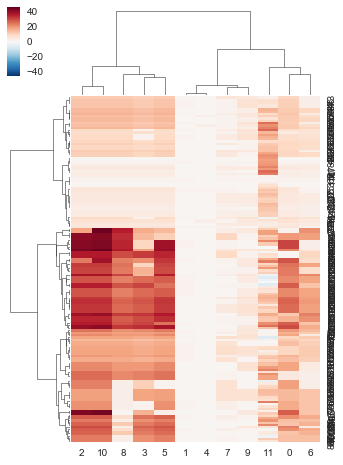

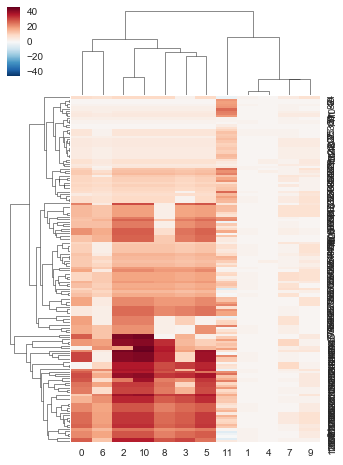

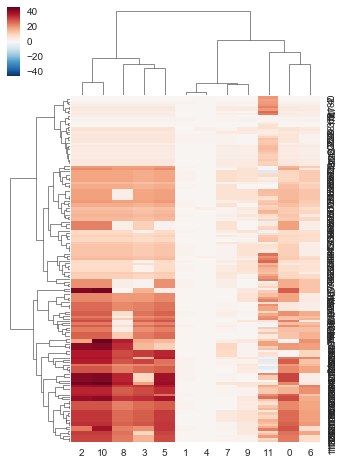

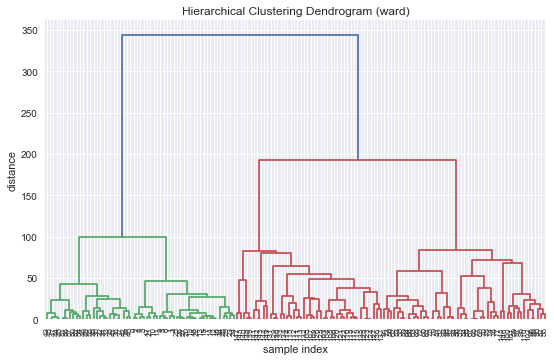

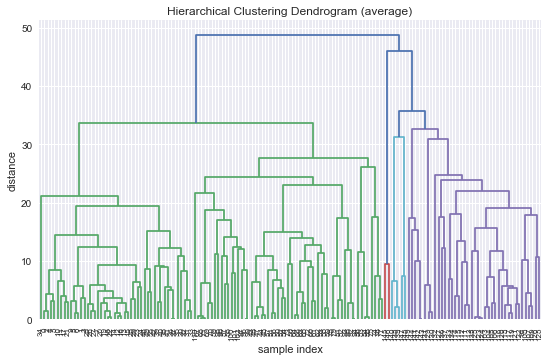

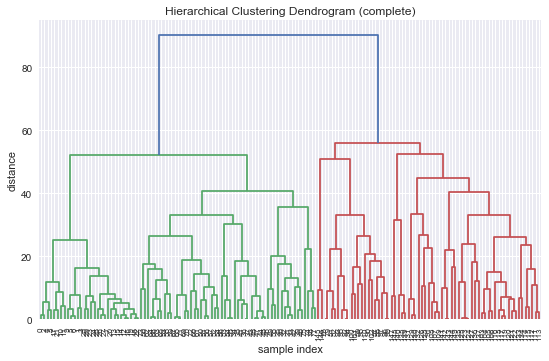

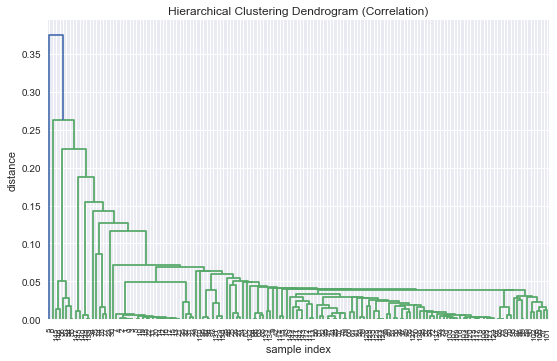

In [68]:
#showdata(data)
hca(raw_data,'euclidean')

### HCA with standarized data  (Euclidean * 3 methods & Correlation)

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


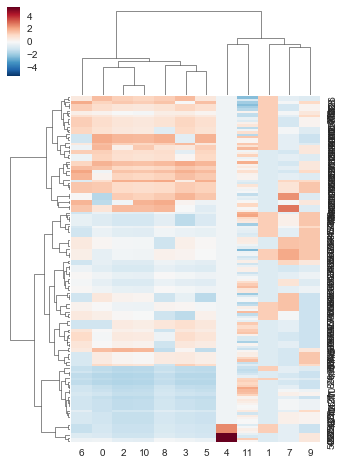

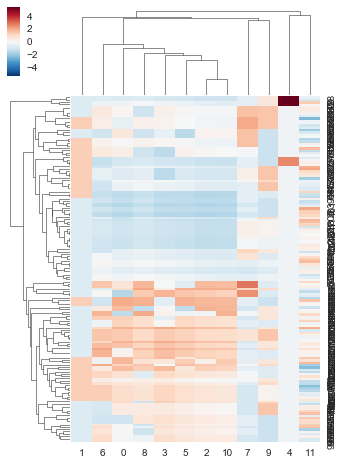

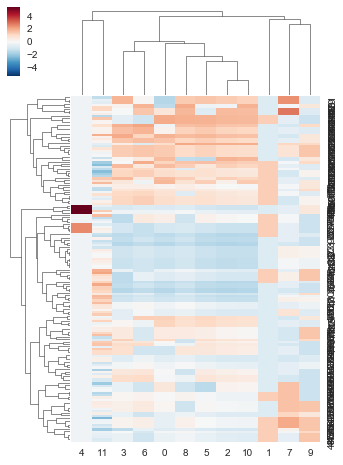

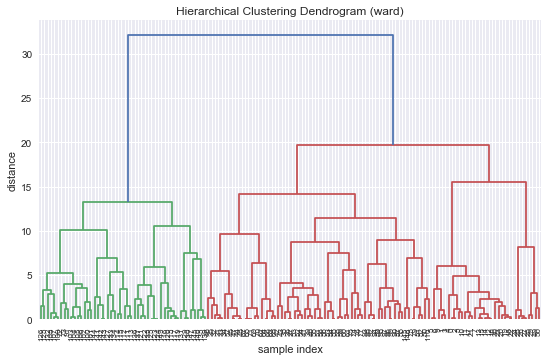

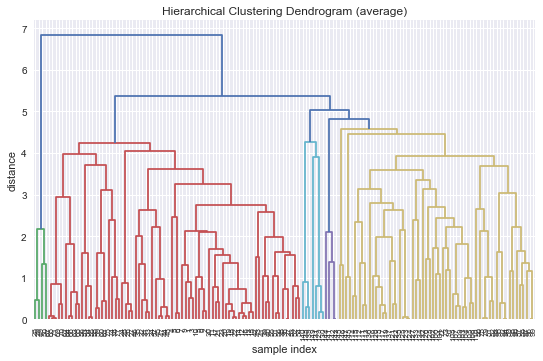

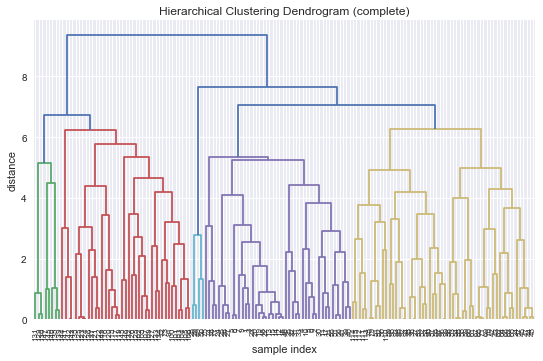

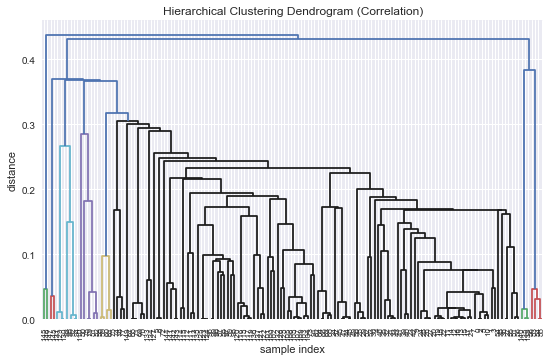

In [69]:
hca(scaled_data,'euclidean')

### HCA with PCA data (Euclidean * 3 methods & Correlation)

C:\Program Files\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Program Files\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


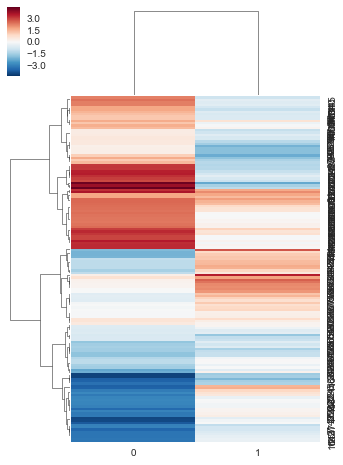

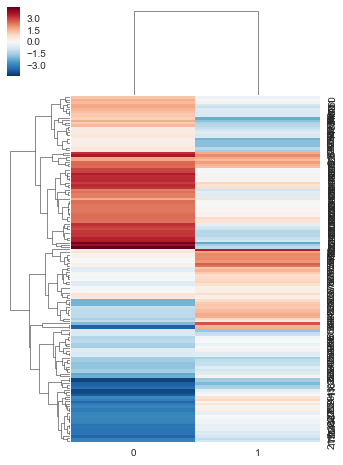

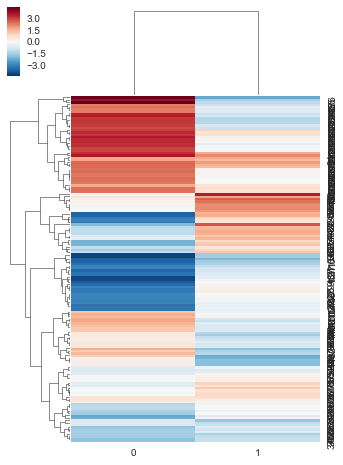

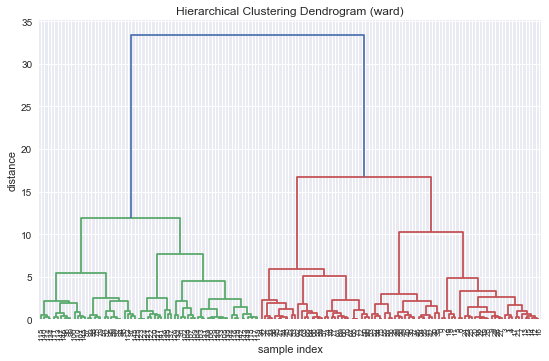

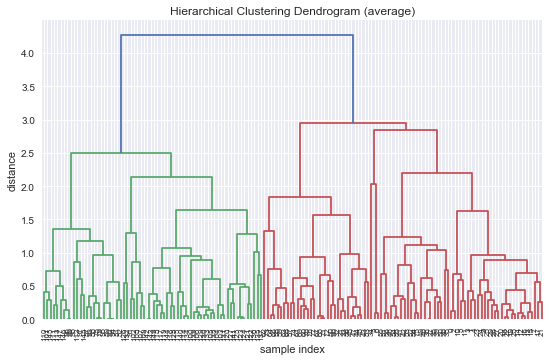

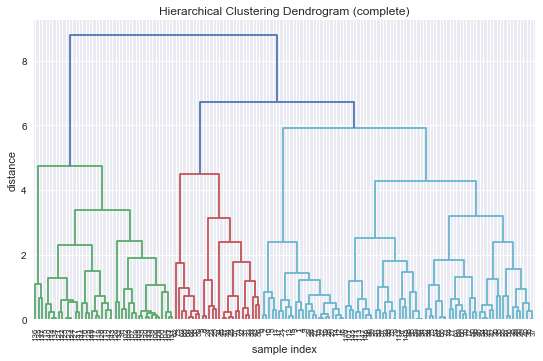

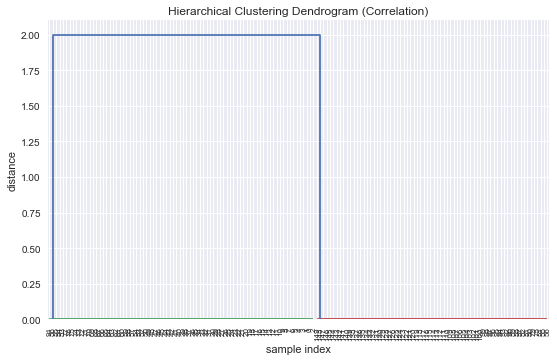

In [70]:
hca(pca_data,'euclidean')